In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

**PASO 1** - Preparación y Exploración de Datos: Realizar limpieza de datos (eliminación de valores nulos y duplicados).


In [51]:
import pandas as pd

# Cargar el archivo con el delimitador incorrecto
df = pd.read_csv("data/raw/clothes_price_prediction_dat.csv", sep=';', header=0, skiprows=1)

# Eliminar filas vacías o con valores NaN
df = df.dropna(how="all")

# Eliminar duplicados
df = df.drop_duplicates()

# Tomar la primera fila como nombres de columnas
df.columns = df.iloc[0]  # Asignar la primera fila como encabezado
df = df[1:]  # Eliminar la primera fila

# Separar correctamente las columnas usando la coma como delimitador
df = df[df.columns[0]].str.split(',', expand=True)

# Asignar nombres de columnas correctos
df.columns = ["Brand", "Category", "Color", "Size", "Material", "Price"]

# Guardar el archivo corregido con el delimitador correcto (coma)
df.to_csv("data/processed/dataset_clean.csv", index=False, sep=',')
df.to_parquet("data/processed/dataset_clean.parquet", index=False)


In [52]:
# Cargar los datos
df = pd.read_csv('data/processed/dataset_clean.csv', sep=',')

#ver los datos del archivvo
df.head()

# Exploración inicial
print(df.describe())
plt.show()


            Price
count  999.000000
mean   106.213213
std     53.668802
min     10.000000
25%     59.500000
50%    108.000000
75%    150.000000
max    199.000000


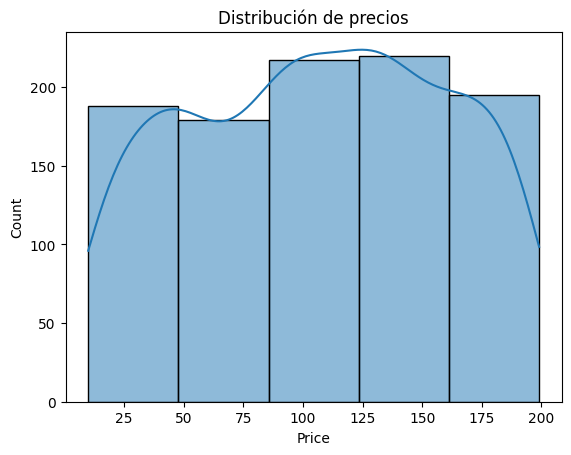

In [53]:
# Histograma con curva de densidad
sns.histplot(df["Price"], bins=5, kde=True)  
plt.title("Distribución de precios")
plt.show()
#los precios estan equilibrados respecto a la media (106)
#la mayoria de los productos tienen el mismo valor
#la distribución es una campana "normal" simetrica
#La dispersión de los precios es moderada, sin presencia de valores extremadamente alejados a al derecha o la izquierda
#la curva de densidad confirma que la mayoria de los datos se concentra entorno a la media
#Parece que independiente de la categoria, los precios fueron definidos con una unica estrategia de marketing (precios en su mayoria homogeneos)

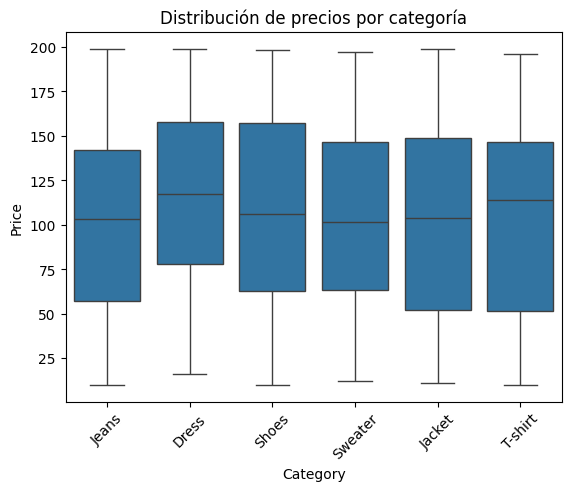

In [54]:
#grafica de precios por categoria
sns.boxplot(data=df, x="Category", y="Price")
plt.xticks(rotation=45)
plt.title("Distribución de precios por categoría")
plt.show()

#Al analizar la distribución de precios de los productos por categoría utilizando un boxplot, se obtiene las siguienets conclusiones:

#1. La categoría Dress y shoes tienen los precios más altos en comparación con las demás categorías (La mediana de esta categoría es  superior a la de las otras, se identifican valñores atipicos)
#2. En general, las categorías presentan una gran cantidad de productos que tienen un precio cercano a 108 (La mayoría de las categorías tienen distribuciones simétricas alrededor de la media, y no se observan muchos valores atipicos)
#3. La categoría T-shirt tiene la mayor cantidad de productos con precios más bajos (la mediana de esta categoría es la más baja entre todas, y la mayoría de los datos se agrupan en el rango inferior)
#4. En promedio las categorías Jeans, Shoes, Sweater y Jacket tienen cantidad similar de productos baratos y costosos (No presentan un sesgo evidente en la distribución de precios)
#5. Las diferencias de precios entre cada categoria podria estar realacionada al tipo de producto y mmaterial con el que se hace

**PASO 2**: Entrenar un modelo de Machine Learning para predecir precios.

In [55]:
# Se selecciona un modelo basado en árboles, ya que estos ofrecen mejores resultados cuando predominan las variables categóricas.
# En este caso, se opta por CatBoost porque maneja las variables categóricas de forma nativa, lo que elimina la necesidad de transformarlas.
# Otra razón es que el volumen de datos no es tan alto.
# Se realizaron múltiples iteraciones para ajustar los hiperparámetros. La asignación actual representa la configuración más óptima encontrada para este problema.

#definir la variable objetivo y las variables predictoras
X = df.drop("Price", axis=1)
Y = df["Price"]

#dividir el dataset en entrenamiento y test, el 20% para pruebas y el 80% para entrenar
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

#se definene las variables categoricas
cat_features = ['Brand','Category','Color','Size','Material']

# Crear Pools para CatBoost que indiquen las variables categóricas
train_pool = Pool(data=X_train, label=Y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=Y_test, cat_features=cat_features)


# Inicializar y entrenar el modelo CatBoostRegressor con los hiperparámetros básicos.
model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.03,
    depth=6,
    verbose=100,
    random_state=42
)

# Entrenar el modelo con early stopping para evitar sobreentrenamiento
model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)

#Evaluar el modelo
Y_pred = model.predict(X_test)
mse_catBoost = mean_squared_error(Y_test, Y_pred)
rmse_catboost = np.sqrt(mean_squared_error(Y_test, Y_pred))
r2_mse_catBoost = r2_score(Y_test, Y_pred)


print("CatBoost MSE:", mse_catBoost)
print("CatBoost RMSE:", rmse_catboost)
print("CatBoost R²:", r2_mse_catBoost)



0:	learn: 54.3100136	test: 50.8134044	best: 50.8134044 (0)	total: 1.31ms	remaining: 655ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 50.81333331
bestIteration = 1

Shrink model to first 2 iterations.
CatBoost MSE: 2581.9948418279378
CatBoost RMSE: 50.81333330758707
CatBoost R²: -0.0007429491846802083


In [56]:
# se entrenan dos modelos adicionales para evaluar el rendimiento del modelo 

# Convertir las variables categóricas en formato numérico
encoder = OneHotEncoder(drop="first", sparse_output=False) 
X_encoded = encoder.fit_transform(X)

#dividir el dataset en entrenamiento y test, el 20% para pruebas y el 80% para entrenar
X_train, X_test, Y_train, Y_test = train_test_split(X_encoded, Y, test_size=0.2, random_state=42)

# Entrenar modelos
liner_model = LinearRegression()
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Variables para Entrenamiento
liner_model.fit(X_train, Y_train)
random_forest_model.fit(X_train, Y_train)

# Variables para pruebas
Y_pred_liner_model = liner_model.predict(X_test)
Y_pred_random_forest_model = random_forest_model.predict(X_test)

# Evaluar modelos con RMSE
rmse_liner_model = np.sqrt(mean_squared_error(Y_test, Y_pred_liner_model))
rmse_random_forest_model = np.sqrt(mean_squared_error(Y_test, Y_pred_random_forest_model))

print("lineal model RMSE:", rmse_liner_model)
print("Random forestmodel RMSE:", rmse_random_forest_model)

# Guardar las métricas en un archivo JSON
metrics = {
    "Linear Model RMSE": rmse_liner_model,
    "Random Forest RMSE": rmse_random_forest_model,
    "CatBoost MSE": mse_catBoost,
    "CatBoost RMSE": rmse_catboost,
    "CatBoost R2": r2_mse_catBoost
}

with open("data/processed/metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)


lineal model RMSE: 51.457282603678856
Random forestmodel RMSE: 54.96457552214824


**PASO 3: Justificar la selección del modelo y evaluar su rendimiento**

Para la prediccion de precios se evaluaron tres modelos Regresión Lineal, Random Forest y CatBoostRegressor. las metricas de evaluación son las siguientes:

* lineal model RMSE: 51.457282603678856
* Random forestmodel RMSE: 54.96457552214824
* CatBoost RMSE: 50.81333330758707

El modelo CatBoostRegressor mostró el menor Error Medio Cuadrático **(RMSE = 50.81)**, lo que indica que sus predicciones están más cerca de los valores reales en comparación con los otros modelos evaluados. Sin embargo, su coeficiente de determinación **(R² = -0.00074294)** es extremadamente bajo, lo que sugiere que el modelo no está capturando bien la variabilidad de los datos. Esto podría indicar que las características disponibles no explican adecuadamente el precio o que el conjunto de datos no es lo suficientemente representativo.

**PASO 4: Integración del proceso en un pipeline automatizado**

el desarrollo del pipeline se podria abordar con el siguiente enfoque:

1. **Extracción de Datos:** Los datos pueden ser leídos desde un bucket de AWS S3 o un Azure Blob Storage. Este proceso puede ser orquestado mediante Azure Data Factory o AWS Glue.
2. **Limpieza y Preparación de Datos:** Se ejecuta un script en Python que contiene las funciones de limpieza y transformación de datos. Este paso puede ser orquestado por Azure Data Factory, que, luego de leer los datos de la fuente, ejecuta el script en un cluster de Databricks.
3. **Entrenamiento del Modelo y Evaluación de Métricas:** Se entrenan diferentes modelos utilizando los datos procesados y se evalúan las métricas de rendimiento como RMSE, R², precisión, etc. y se selecciona el modelo que mejor minimiza el error.
4. **Optimización de Hiperparámetros:** Durante el entrenamiento, se usa una herramienta de optimización de hiperparámetros como Optuna para mejorar la precisión del modelo.
5. **Almacenamiento de Resultados y Comparación con Modelos Anteriores:** Se guardan las métricas del modelo, los hiperparámetros y el backtest en una base de datos SQL. En futuros reentrenamientos, se compara el nuevo modelo con el modelo anterior. Si el nuevo modelo obtiene mejores resultados, se selecciona para despliegue.
6. **Despliegue del Modelo:** Se implementa el modelo para que pueda ser consumido como API. Se puede utilizar una Azure Function, una Lambda o Databricks para exponer el modelo y sea consumido por otra aplicación.